In [1]:
import os
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from openpyxl.utils import get_column_letter
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary

In [15]:
ruta_carpeta = "/Users/Usuario/OneDrive/Escritorio/tfg/probeta 1/"
num_ensayos=11
nombres_archivos = [f"ENSAYO_{i}.xlsx" for i in range(num_ensayos)]

# Intervalo de frecuencias de cada canal
intervalo_canales = [
    (4, 804),      
    (810, 1610),   
    (1616, 2416),
    (2422, 3222),
    #(3228, 4028), Nos saltamos el sensor 5
    (4034, 4834),
    (4840, 5640),
    (5646, 6446),
    (6452, 7252),
    (7258, 8058)
]
# Definir las columnas de frecuencia, parte real y parte imaginaria para cada rango
frecuencia_col = [1, 4, 7, 10, 13, 16, 19, 22, 25]  # A, D, J
real_col = [2, 5, 8, 11, 14, 17, 20, 23, 26]  # B, E, K
imagin_col = [3, 6, 9, 12, 15, 18, 21, 24, 27]  # C, F, L
# Convertimos estas a letras para el print
frecuencia_col_letras = [get_column_letter(col) for col in frecuencia_col]
real_col_letras = [get_column_letter(col) for col in real_col]
imagin_col_letras = [get_column_letter(col) for col in imagin_col]

In [16]:
# Obtenemos las partes reales e imagin separadas por ensayo, hojas, canales y rangos
data_frecuencias = []
data_partes_reales = []
data_partes_imagin = []
for ensayo_idx, nombre_archivo in enumerate(nombres_archivos):
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    wb = openpyxl.load_workbook(ruta_archivo)

    sweep1=wb['Sweep_1']
    sweep2=wb['Sweep_2']
    sweep3=wb['Sweep_3']
    
    sweeps = [sweep1, sweep2, sweep3]
    
    if ensayo_idx == 0:  # Solo se almacena una vez porque las frecuencias no cambian entre ensayos
        for col in frecuencia_col:
            column_data = [sweeps[0].cell(row=i, column=col).value for i in range(4, 805)]
            data_frecuencias.append(column_data)

    ensayo_partes_reales = []
    ensayo_partes_imagin = []
    
    for sheet in sweeps:
        sweep_data_reales = []
        sweep_data_imagin = []
        for inicio, fin in intervalo_canales:
            canal_data_reales = []
            canal_data_imagin = []
            for col_r, col_i in zip(real_col, imagin_col):
                column_data_reales = [sheet.cell(row=i, column=col_r).value for i in range(inicio, fin + 1)]
                column_data_imagin = [sheet.cell(row=i, column=col_i).value for i in range(inicio, fin + 1)]
                canal_data_reales.append(column_data_reales)
                canal_data_imagin.append(column_data_imagin)
            sweep_data_reales.append(canal_data_reales)
            sweep_data_imagin.append(canal_data_imagin)
        ensayo_partes_reales.append(sweep_data_reales)
        ensayo_partes_imagin.append(sweep_data_imagin)
    data_partes_reales.append(ensayo_partes_reales)
    data_partes_imagin.append(ensayo_partes_imagin)

In [17]:
# Ahora, imprimir las partes reales y las imaginarias para comprobar la estructura
# print("\nPartes Reales y Partes Imaginarias:")

# Recorremos los datos de partes reales e imaginarias
# for ensayo_idx, (sweep_reales, sweep_imagin) in enumerate(zip(data_partes_reales, data_partes_imagin), start=1):
#     print(f"\nEnsayo {ensayo_idx-1}:")
#     for sweep_idx, (sweep_data_reales, sweep_data_imagin) in enumerate(zip(sweep_reales, sweep_imagin), start=1):
#         print(f"  Barrido {sweep_idx}:")
        
#         for canal_idx, (canal_reales, canal_imagin) in enumerate(zip(sweep_data_reales, sweep_data_imagin), start=1):
#             print(f"    Canal {canal_idx}:")
#             for col_idx, (column_reales, column_imagin) in enumerate(zip(canal_reales, canal_imagin), start=1):
#                 print(f"      Columna {real_col_letras[col_idx-1]}:")
#                 print(f"        Parte Real (primeros 5 valores): {column_reales[:5]}")
#                 print(f"        Parte Imaginaria (primeros 5 valores): {column_imagin[:5]}")


In [18]:
data_frecuencias_np = np.array(data_frecuencias)
data_partes_reales_np = np.array(data_partes_reales)
data_partes_imagin_np = np.array(data_partes_imagin)

In [19]:
data_frecuencias_np.shape

(9, 801)

In [20]:
data_partes_reales_np.shape

(11, 3, 9, 9, 801)

In [21]:
data_partes_imagin_np.shape

(11, 3, 9, 9, 801)

In [22]:
data_partes_reales_np_reshaped = data_partes_reales_np.reshape(data_partes_reales_np.shape[0], data_partes_reales_np.shape[1], data_partes_reales_np.shape[2], -1)
data_partes_imagin_np_reshaped = data_partes_imagin_np.reshape(data_partes_imagin_np.shape[0], data_partes_imagin_np.shape[1], data_partes_imagin_np.shape[2], -1)
data_frecuencias_np_reshaped = data_frecuencias_np.reshape(-1)
print( data_partes_reales_np_reshaped.shape)
print( data_partes_imagin_np_reshaped.shape)
print(data_frecuencias_np_reshaped.shape)

(11, 3, 9, 7209)
(11, 3, 9, 7209)
(7209,)


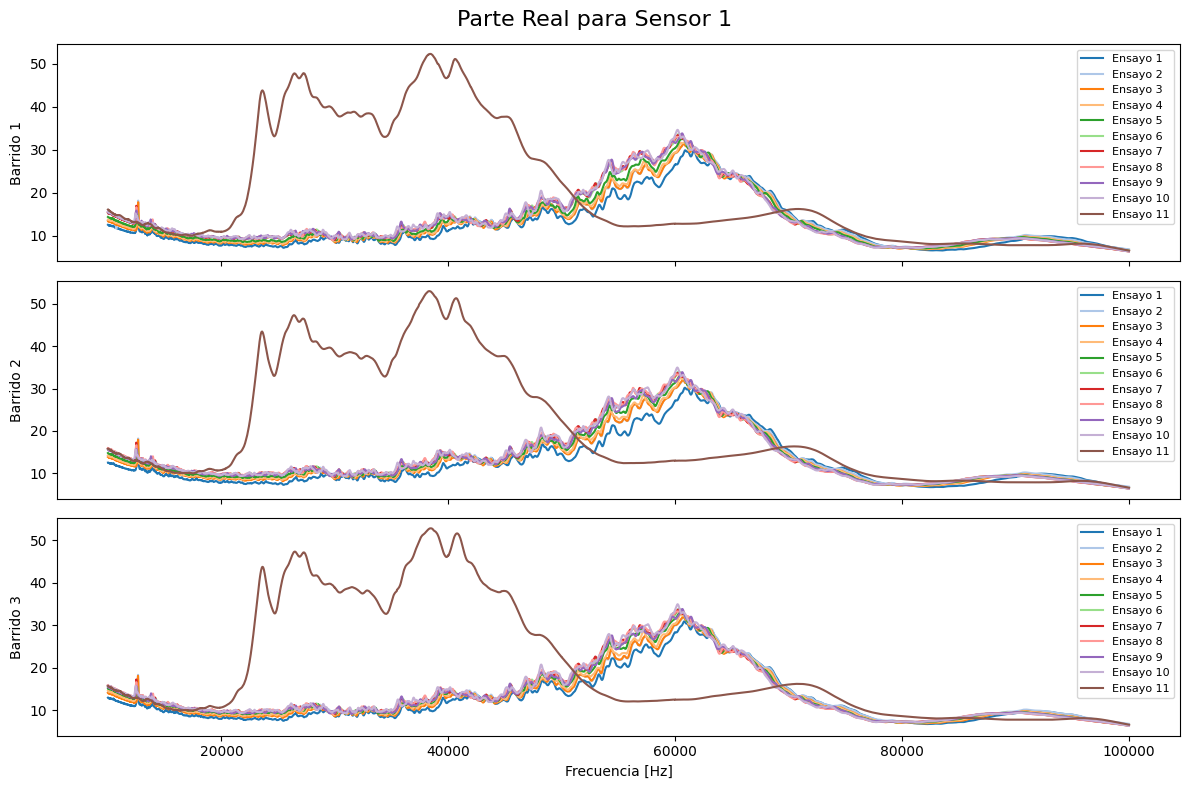

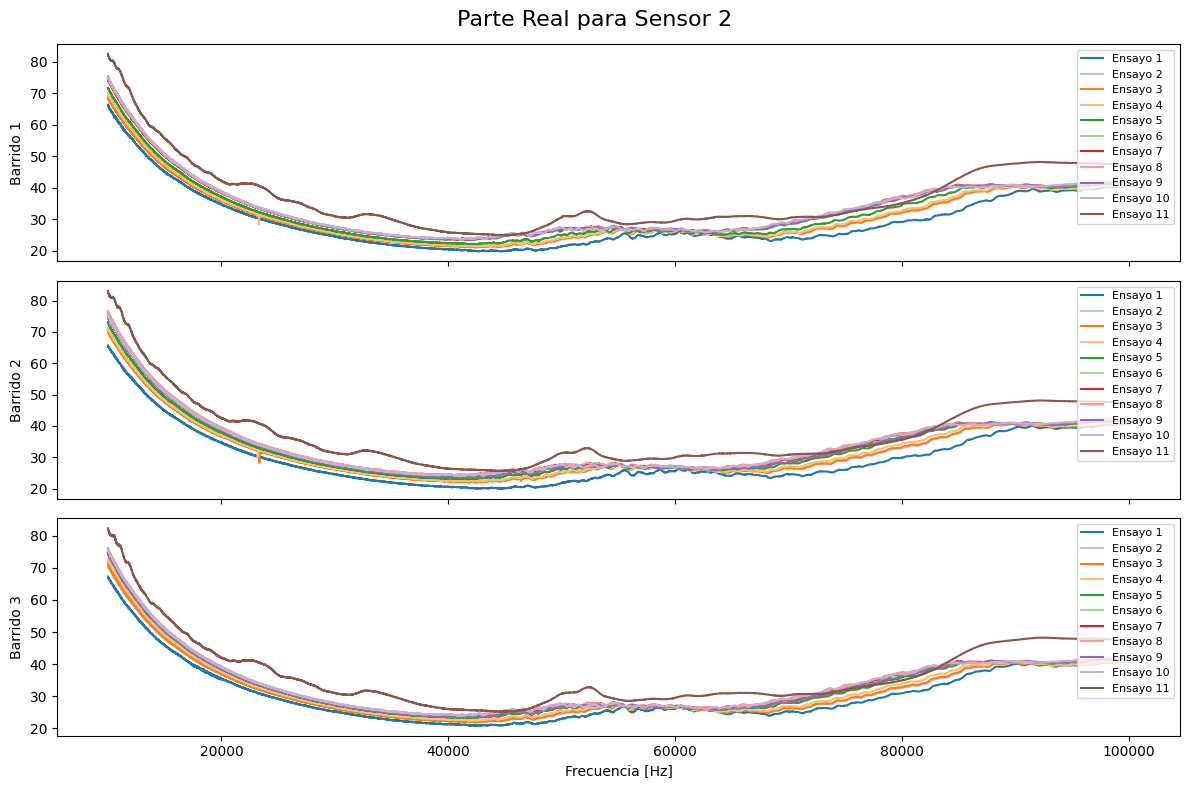

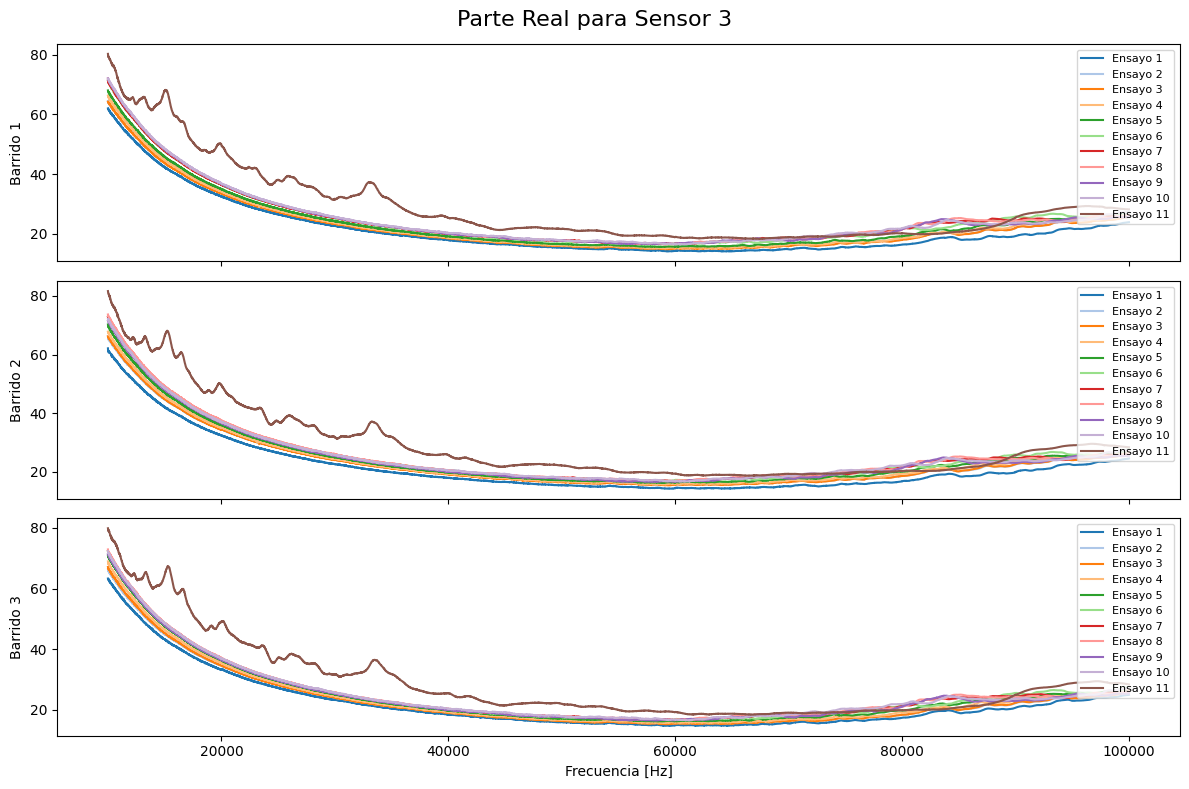

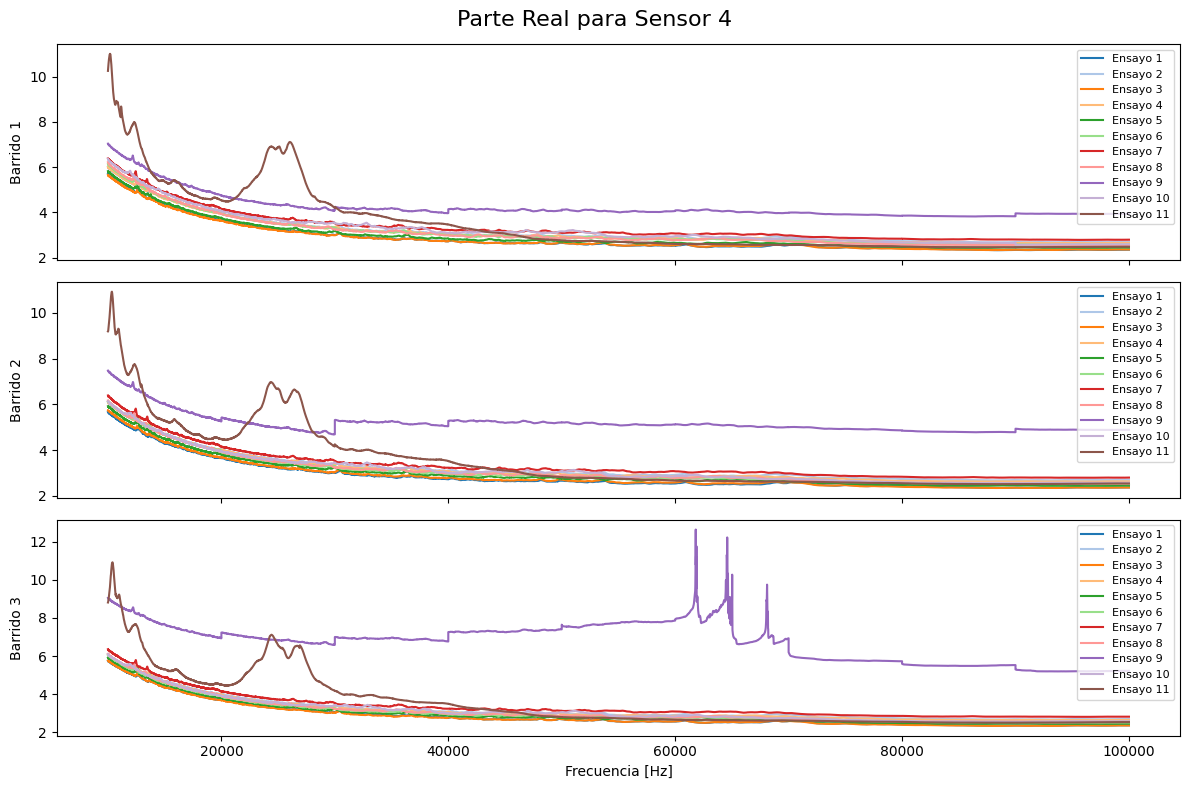

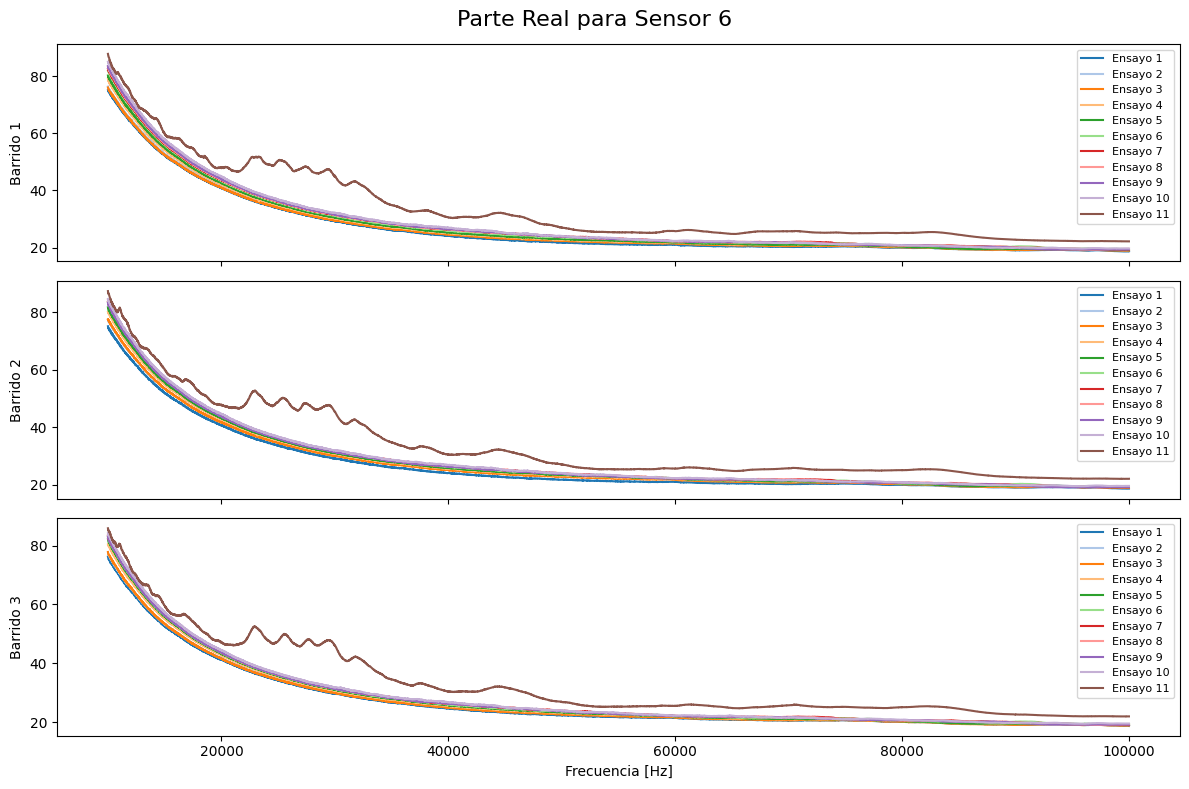

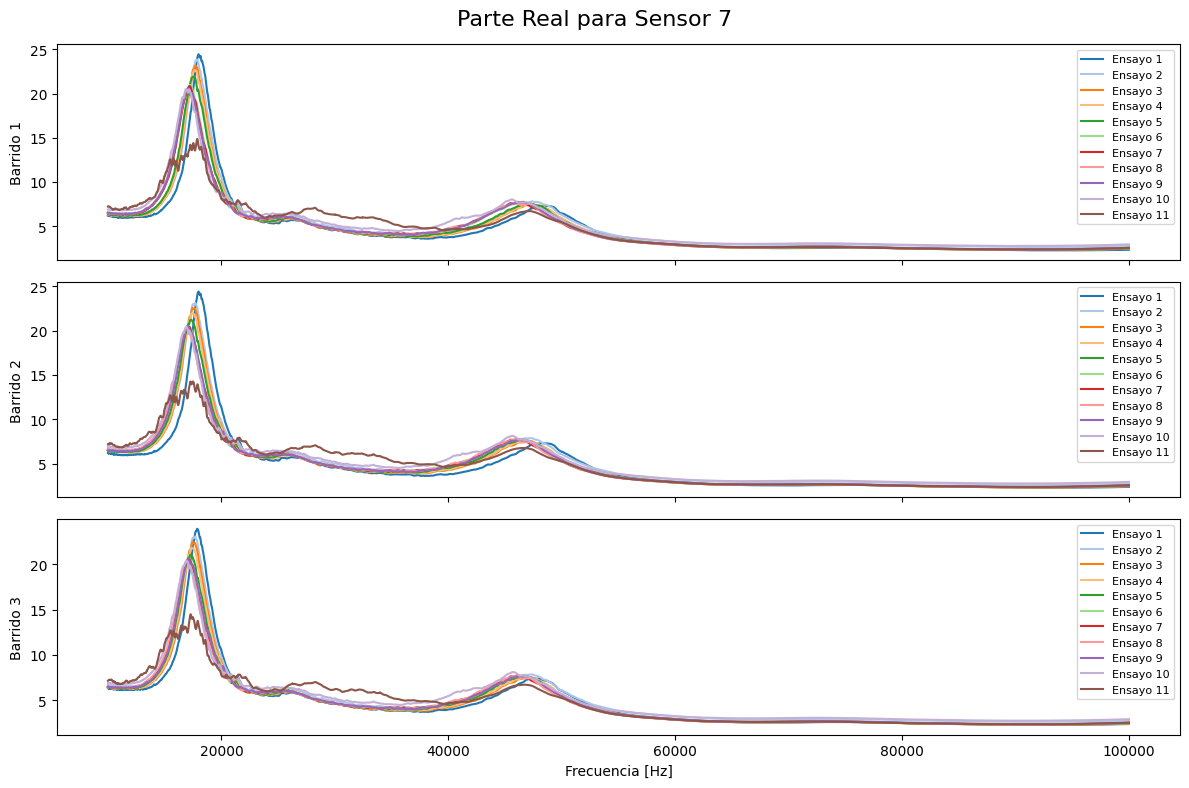

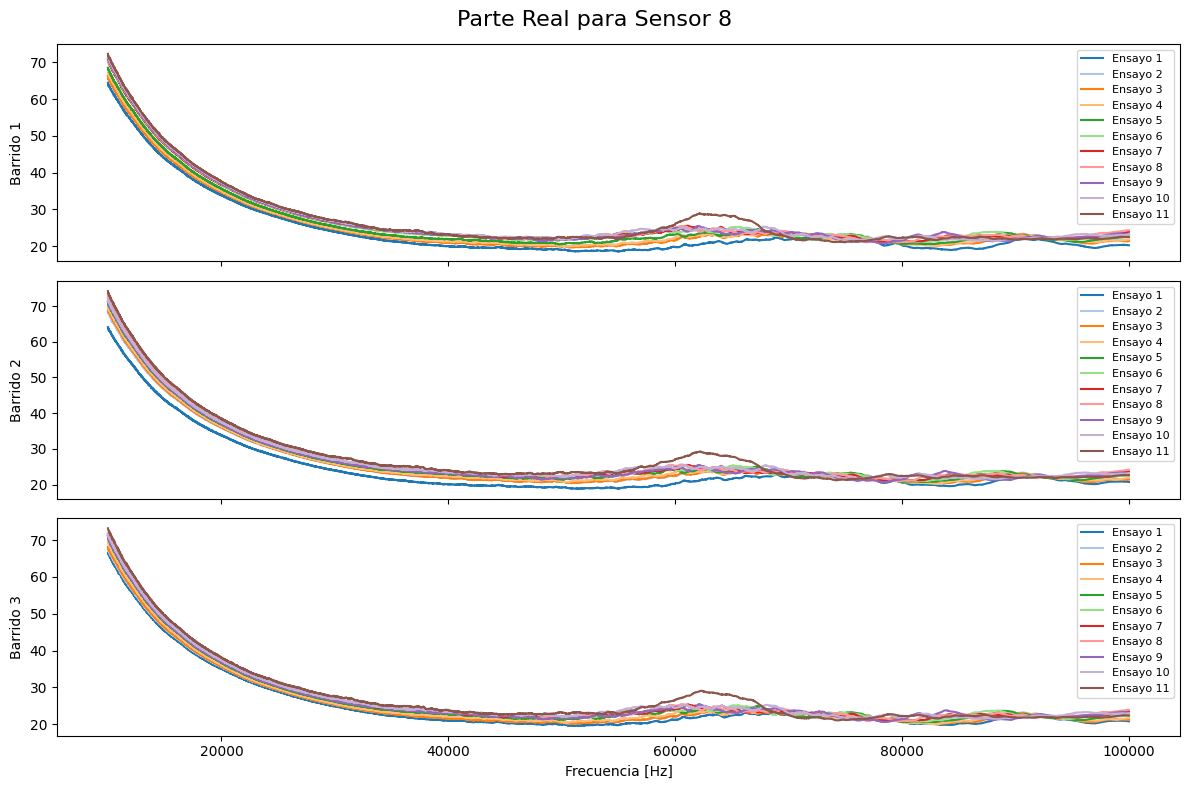

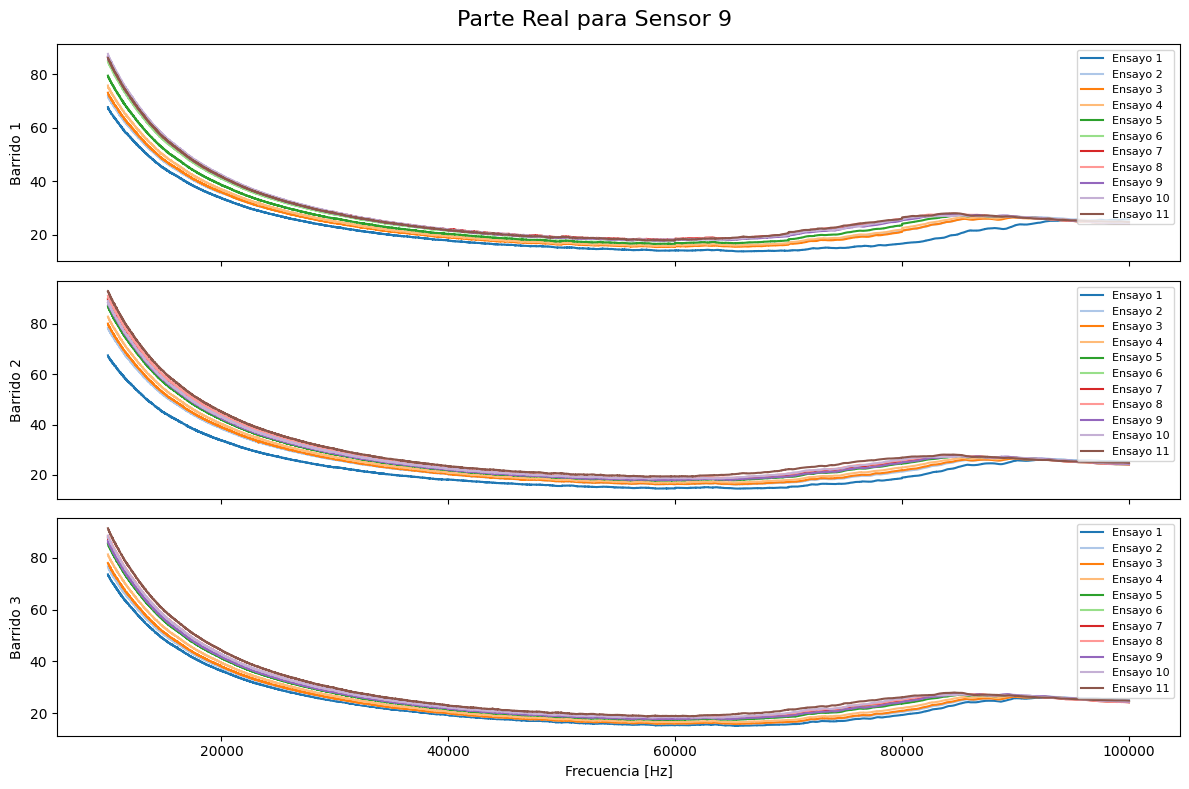

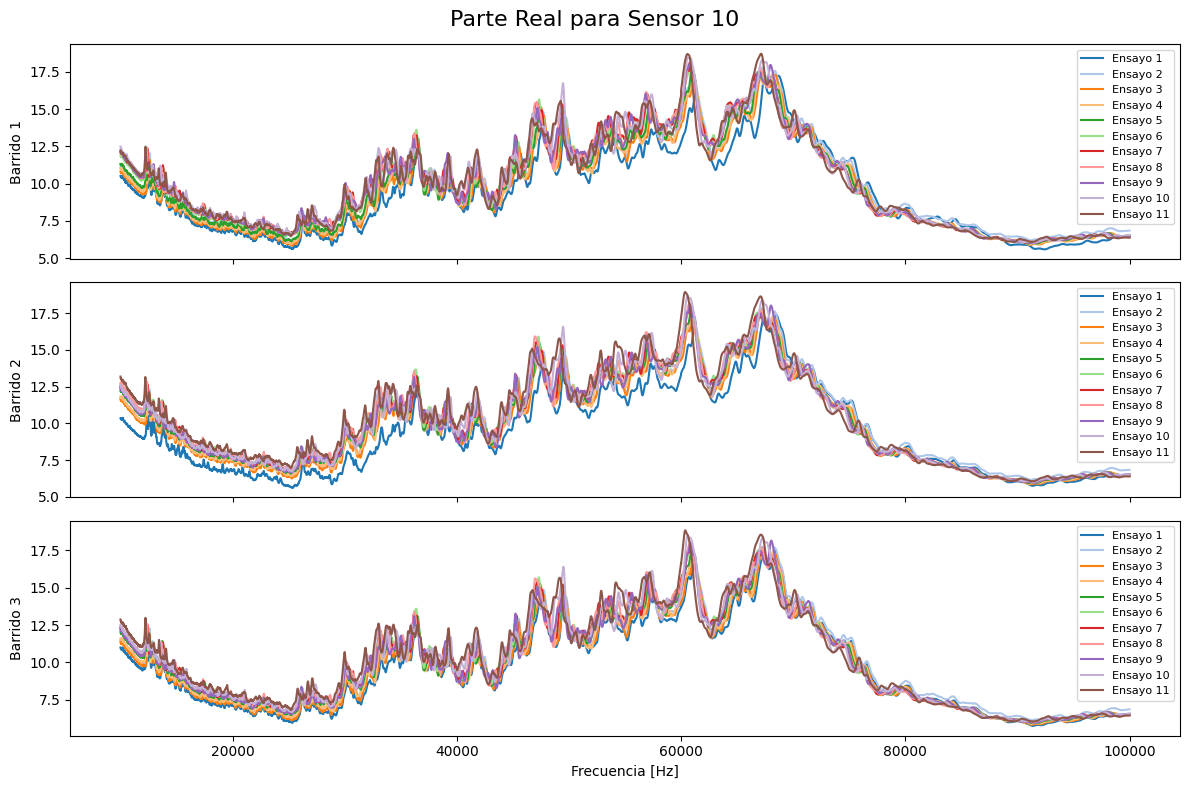

In [23]:
#VISUALIZACIÓN DE SEÑALES: Subplots de las señales separados por sensor, carga y sensor-barrido
n_ensayos, n_barridos, n_sensores, n_puntos = (11, 3, 9, 7209)
colormap = plt.get_cmap("tab20")
# Parte real
for sensor in range(n_sensores):
    fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
    if sensor<4:
        fig.suptitle(f"Parte Real para Sensor {sensor+1}", fontsize=16)
    else: fig.suptitle(f"Parte Real para Sensor {sensor+2}", fontsize=16)
    
    # Iteramos sobre cada barrido
    for barrido in range(n_barridos):
        ax = axs[barrido]  
        for ensayo in range(n_ensayos):
            color = colormap(ensayo % 20)
            ax.plot(data_frecuencias_np_reshaped,data_partes_reales_np_reshaped[ensayo, barrido, sensor], label=f"Ensayo {ensayo+1}", color=color)
        
        ax.set_ylabel(f"Barrido {barrido+1}")
        ax.legend(fontsize=8, loc="upper right")
    
    axs[-1].set_xlabel("Frecuencia [Hz]")
    plt.tight_layout()
    plt.show()

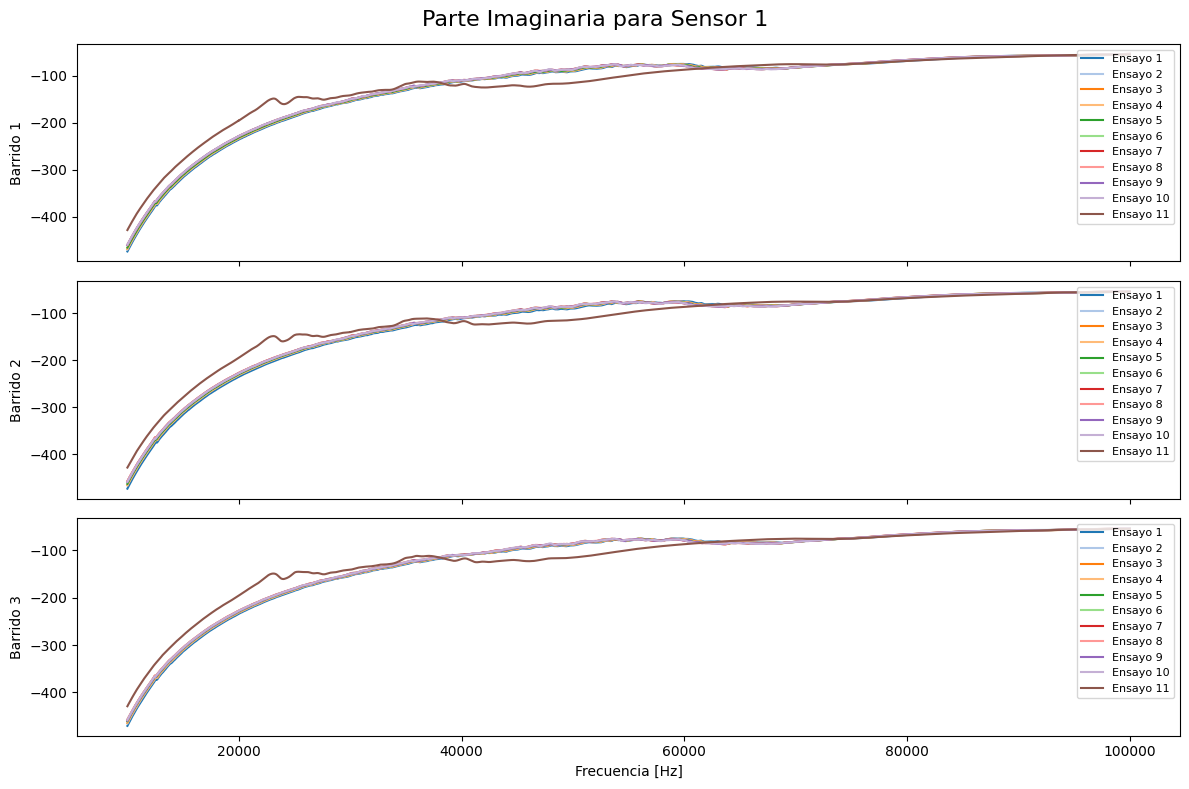

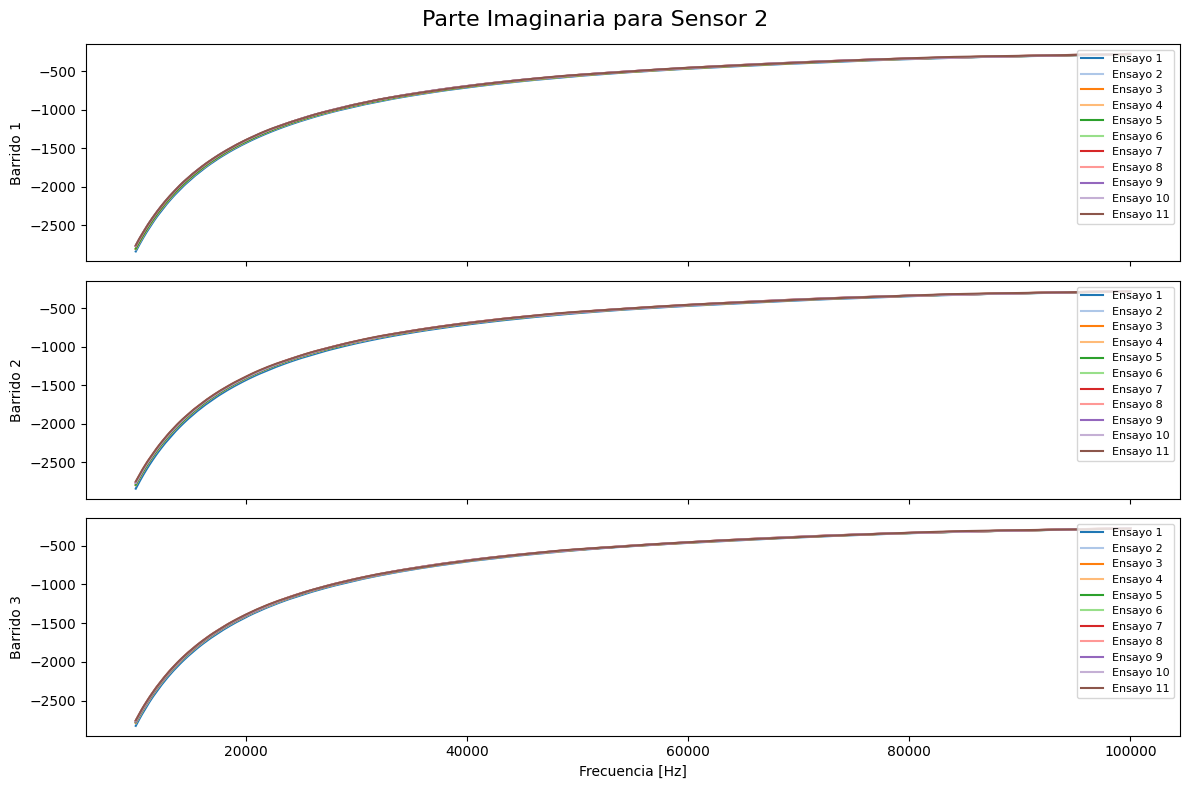

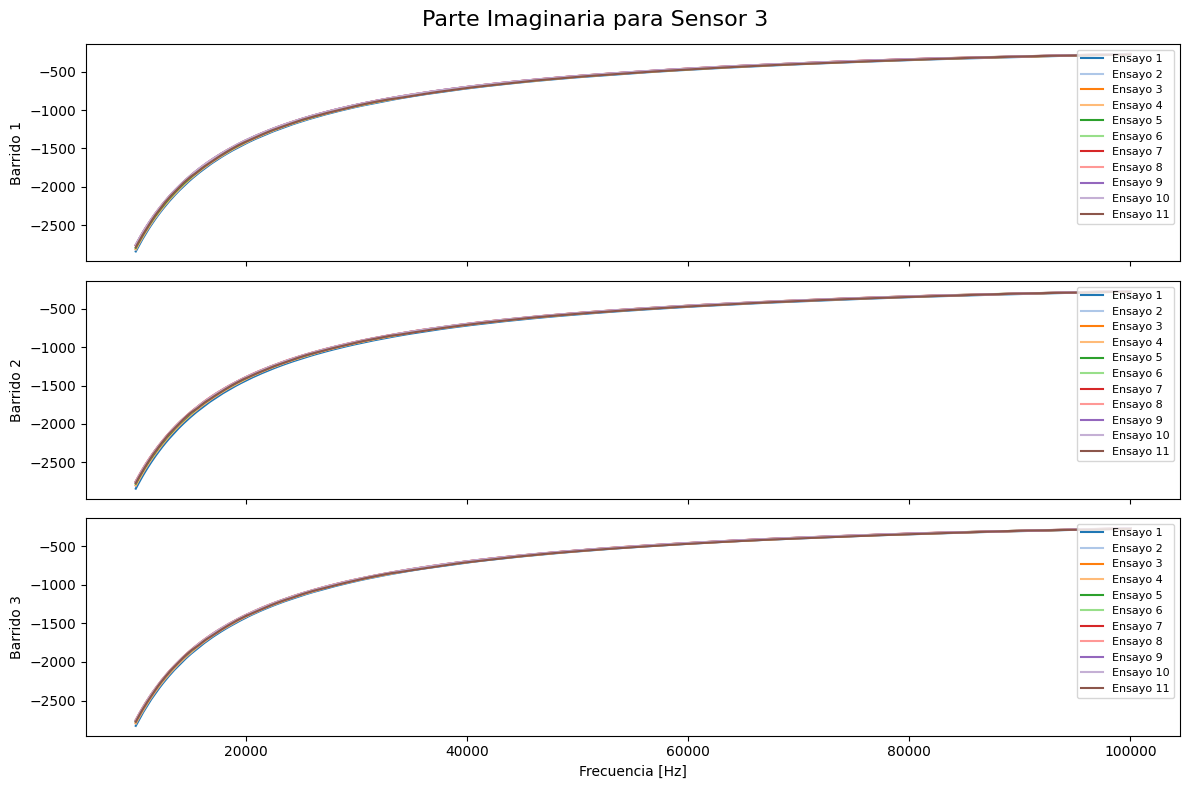

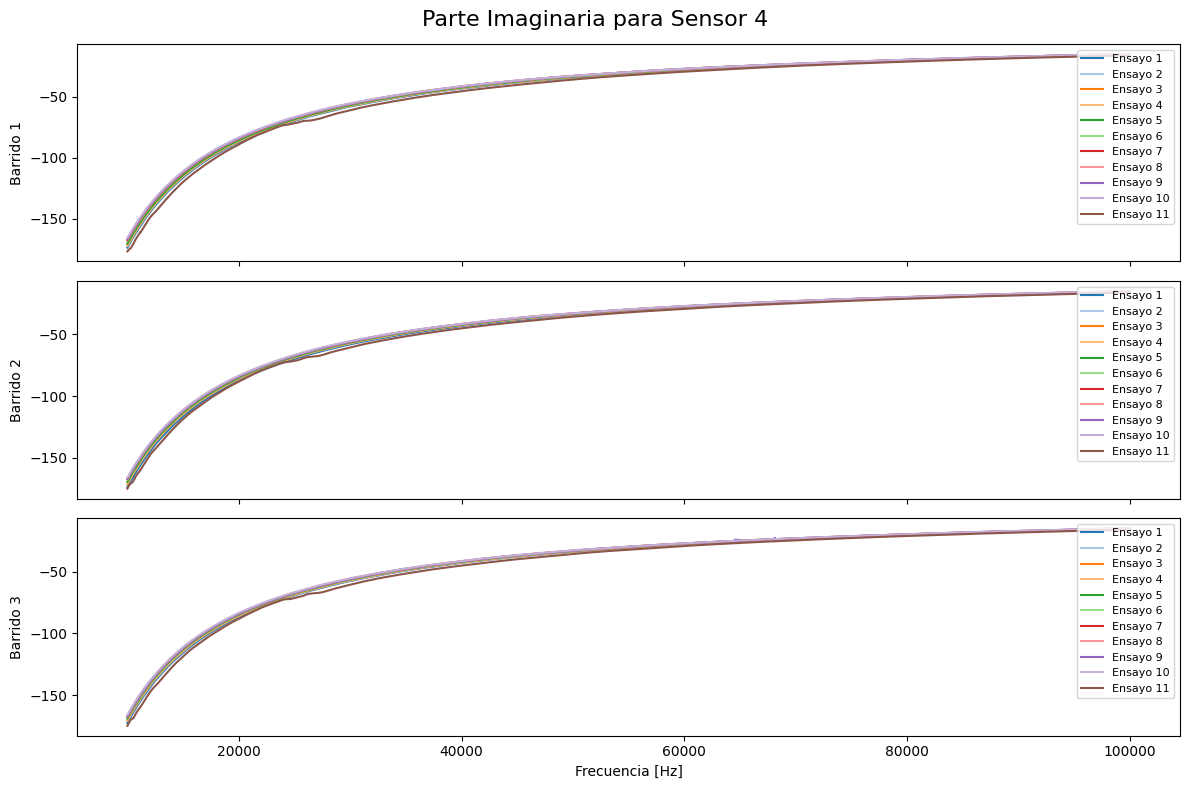

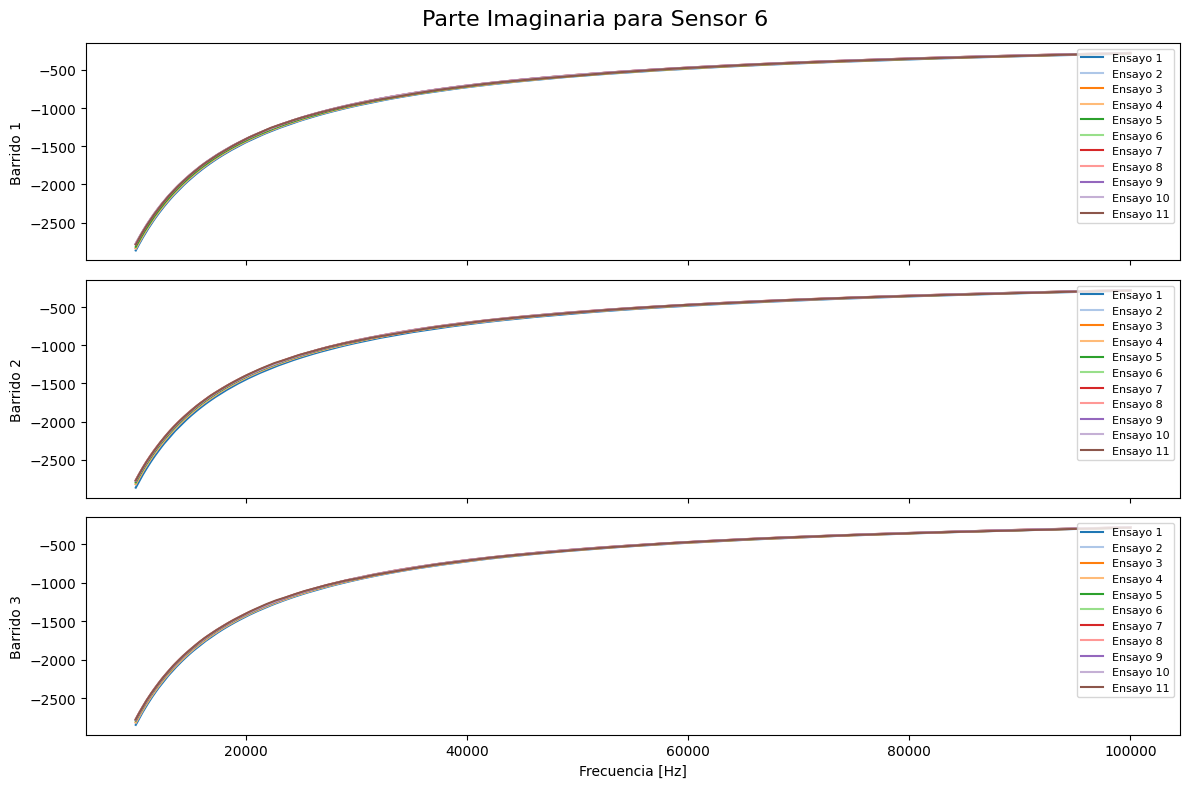

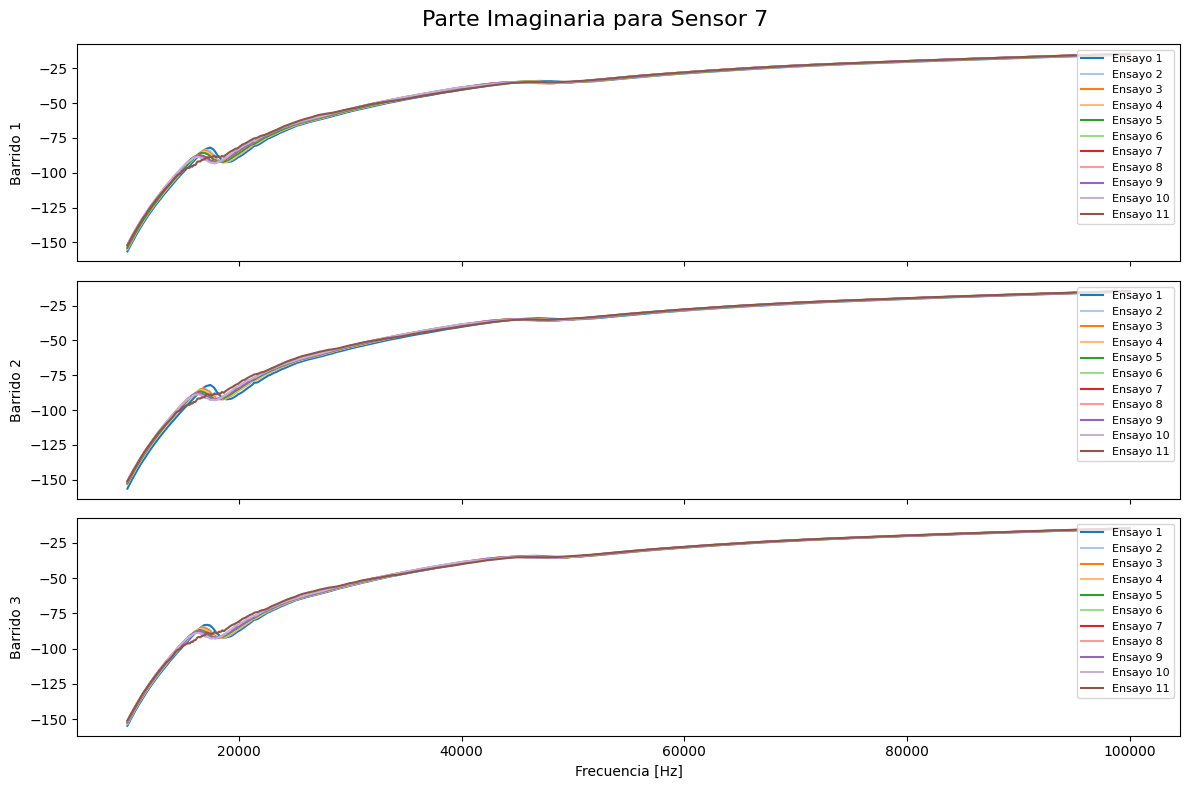

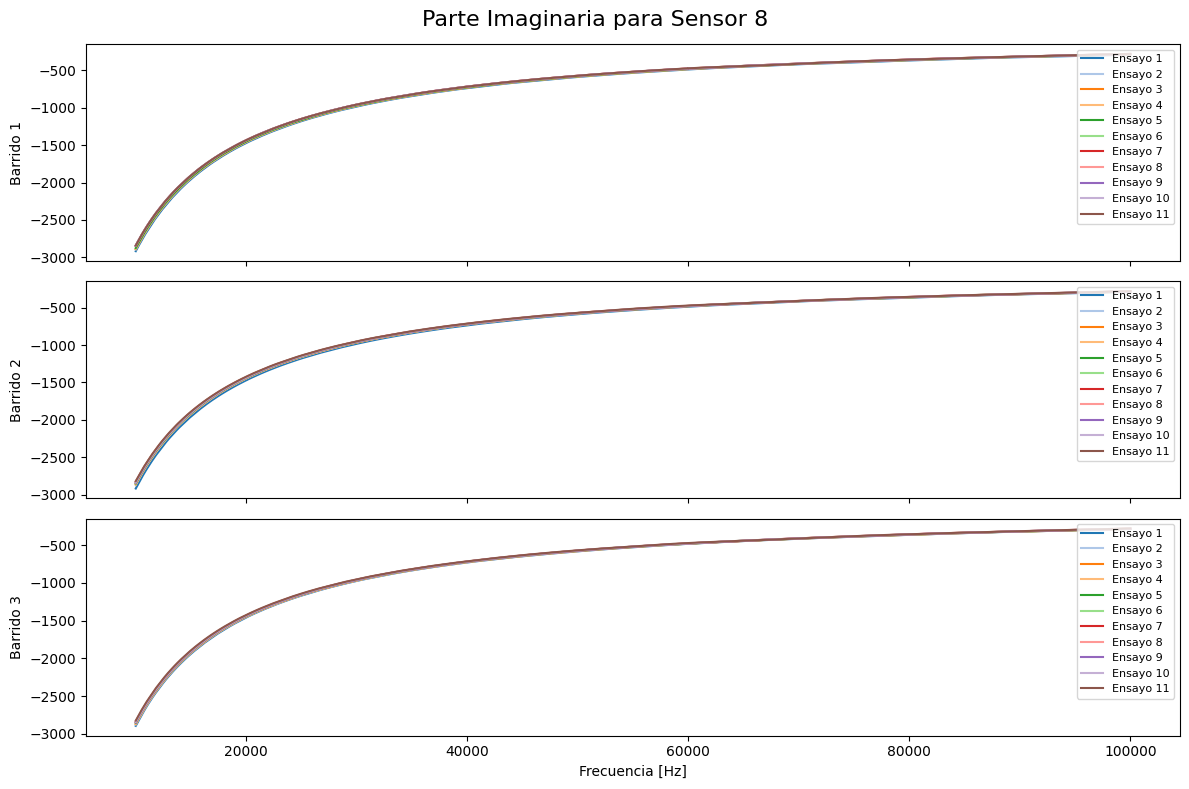

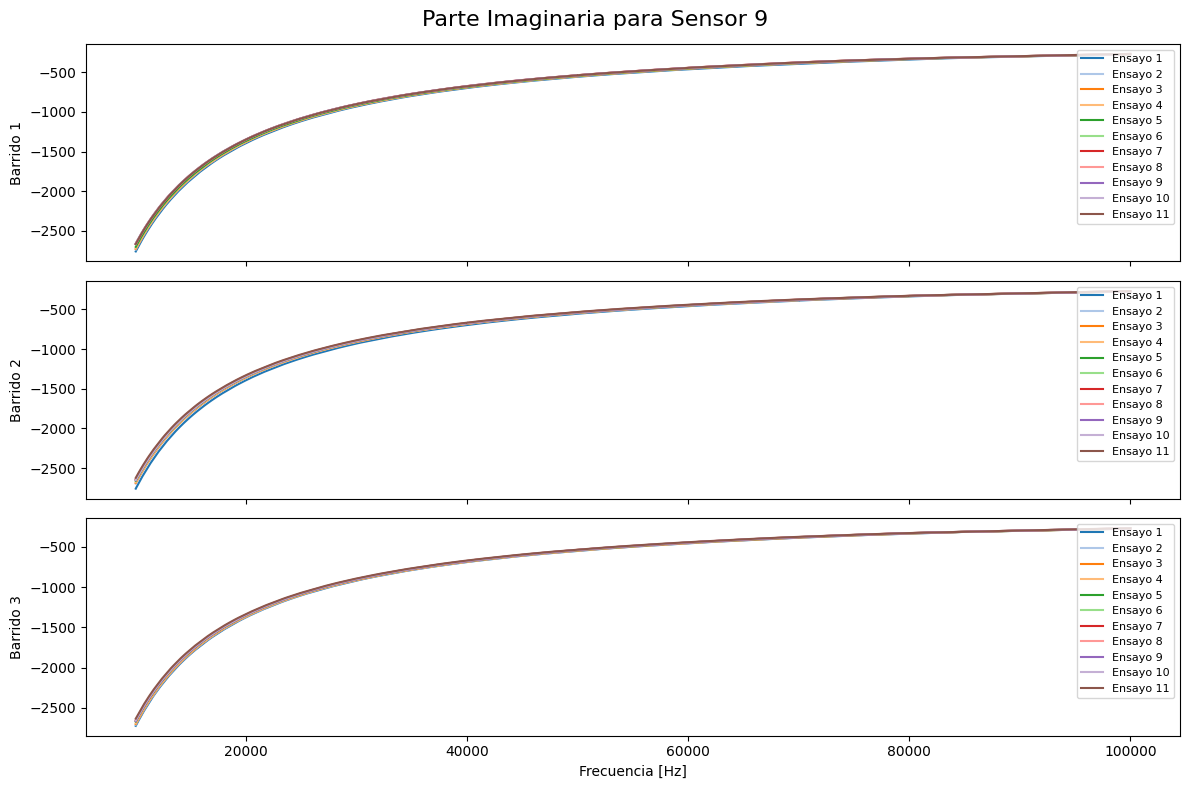

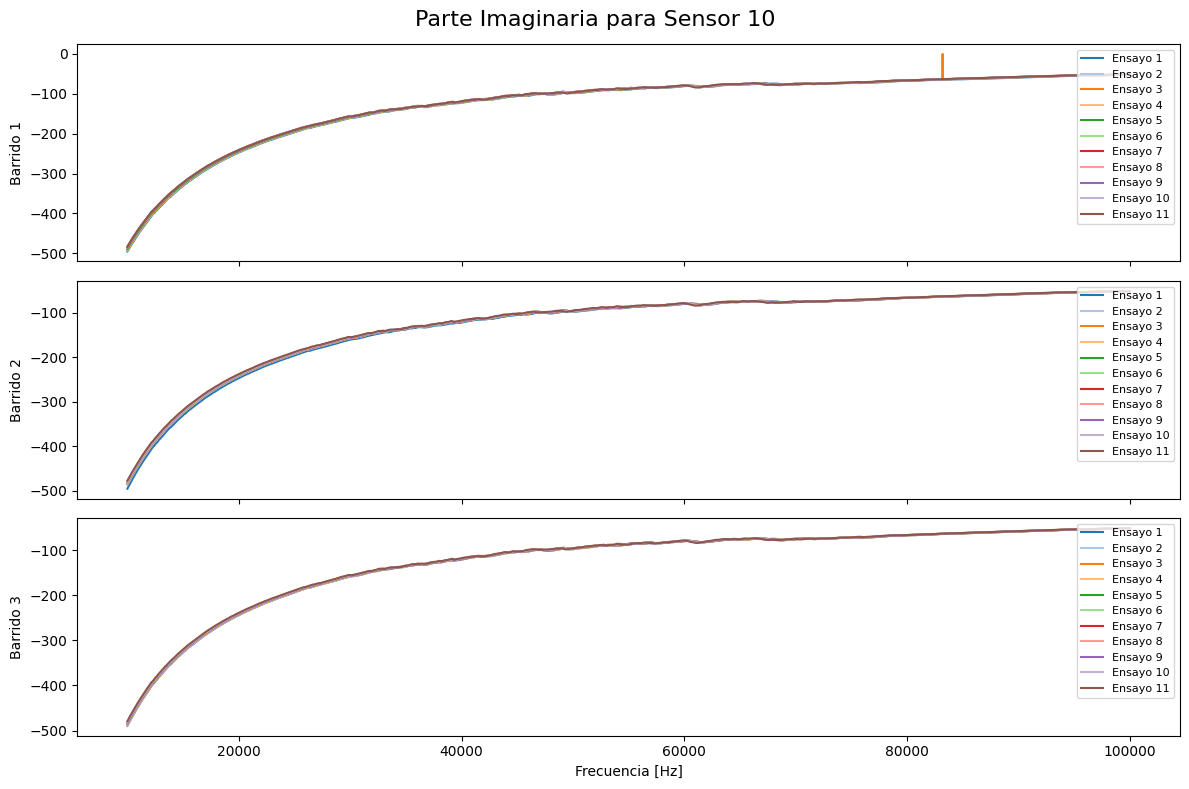

In [24]:
#Parte imaginaria
for sensor in range(n_sensores):
    fig, axs = plt.subplots(n_barridos, 1, figsize=(12, 8), sharex=True) # Creamos una figura con n_barridos subplots (uno por cada barrido).
    if sensor<4:
        fig.suptitle(f"Parte Imaginaria para Sensor {sensor+1}", fontsize=16)
    else: fig.suptitle(f"Parte Imaginaria para Sensor {sensor+2}", fontsize=16)
    
    # Iteramos sobre cada barrido
    for barrido in range(n_barridos):
        ax = axs[barrido]  
        for ensayo in range(n_ensayos):
            color = colormap(ensayo % 20)
            ax.plot(data_frecuencias_np_reshaped,data_partes_imagin_np_reshaped[ensayo, barrido, sensor, :], label=f"Ensayo {ensayo+1}",color=color)
        
        ax.set_ylabel(f"Barrido {barrido+1}")
        ax.legend(fontsize=8, loc="upper right")
    
    axs[-1].set_xlabel("Frecuencia [Hz]")
    plt.tight_layout()
    plt.show()

In [77]:
data_partes_reales_tensor = torch.tensor(data_partes_reales_np_reshaped, dtype=torch.float32)
data_partes_imagin_tensor = torch.tensor(data_partes_imagin_np_reshaped, dtype=torch.float32)
torch.save(data_partes_reales_tensor, 'tensor_emis_real.pt')
torch.save(data_partes_imagin_tensor, 'tensor_emis_imagin.pt')

In [2]:
# data_partes_reales_tensor=torch.load('tensor_emis_real.pt')
# data_partes_imagin_tensor=torch.load('tensor_emis_imagin.pt')

# # Definición del Autoencoder Variacional (VAE)
# class VariationalAutoencoder(nn.Module):
#     def __init__(self, latent_channels=128):
#         super().__init__()
#         self.latent_channels = latent_channels
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv1d(1, 16, 3, stride=2, padding=2),
#             nn.ReLU(),
#             nn.Conv1d(16, 32, 3, stride=2, padding=2),
#             nn.ReLU(),
#             nn.Conv1d(32, 64, 3, stride=2, padding=2),
#             nn.ReLU()
#             # nn.Conv1d(64, 128, 3, stride=2, padding=2),
#             # nn.ReLU(),
#             # nn.Conv1d(128, 512, 3, stride=2, padding=2),
#             # nn.ReLU()
#         )
        
#        # Obtener tamaño de salida del encoder dinámicamente
#         # with torch.no_grad():
#         #     sample_input = torch.randn(1, 1, 7209)
#         #     sample_output = self.encoder(sample_input)
#         #     encoded_dim = sample_output.numel() // sample_output.shape[0]
#         #     print(encoded_dim)

#         self.conv_mu = nn.Conv1d(64, latent_channels, kernel_size=1)
#         self.conv_logvar = nn.Conv1d(64, latent_channels, kernel_size=1)
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(latent_channels, 64, 3, stride=2, padding=2, output_padding=1),
#             nn.ReLU(),
#             # nn.ConvTranspose1d(512, 128, 3, stride=2, padding=2, output_padding=0),
#             # nn.ReLU(),
#             # nn.ConvTranspose1d(128, 64, 3, stride=2, padding=2, output_padding=0),
#             nn.ReLU(),
#             nn.ConvTranspose1d(64, 32, 3, stride=2, padding=2, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose1d(32, 16, 3, stride=2, padding=2, output_padding=0),
#             nn.ReLU(),
#             nn.ConvTranspose1d(16, 1, 3, stride=1, padding=1, output_padding=0),
#             nn.ReLU()
#         )
    
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std
    
#     def forward(self, x):
#         x_encoded = self.encoder(x)           # (B, 64, L)

#         mu = self.conv_mu(x_encoded)          # (B, latent_channels, L)
#         logvar = self.conv_logvar(x_encoded)  # (B, latent_channels, L)

#         z = self.reparameterize(mu, logvar)   # (B, latent_channels, L)

#         x_recon = self.decoder(z)
#         return x_recon, mu, logvar

In [64]:
data_partes_reales_tensor=torch.load('tensor_emis_real.pt')
data_partes_imagin_tensor=torch.load('tensor_emis_imagin.pt')


# Definición del Autoencoder Variacional (VAE)
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 3, stride=2, padding=2),
            nn.ReLU()
        )
        
       # Obtener tamaño de salida del encoder dinámicamente
        with torch.no_grad():
            sample_input = torch.randn(1, 1, 7209)
            sample_output = self.encoder(sample_input)
            encoded_dim = sample_output.numel() // sample_output.shape[0]
            print(encoded_dim)

        self.fc_mu = nn.Linear(encoded_dim, latent_dim)
        self.fc_logvar = nn.Linear(encoded_dim, latent_dim)
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, encoded_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 64, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 32, 3, stride=2, padding=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, 3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, 3, stride=2, padding=2),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplanamos
        #print(f"Tamaño después del encoder: {x.shape}")  # Depuración
        
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        x = self.decoder_fc(z).view(x.size(0), 64, -1)
        x = self.decoder(x)
        return x, mu, logvar

In [65]:
# latent_channels=512
# model = VariationalAutoencoder(latent_channels)
# summary(model, input_size=(64, 1, 7209))

In [66]:
latent_dim=16
model = VariationalAutoencoder(latent_dim)
summary(model, input_size=(64, 1, 7209))

7360


Layer (type:depth-idx)                   Output Shape              Param #
VariationalAutoencoder                   [64, 1, 7209]             --
├─Sequential: 1-1                        [64, 64, 115]             --
│    └─Conv1d: 2-1                       [64, 16, 3606]            64
│    └─ReLU: 2-2                         [64, 16, 3606]            --
│    └─Conv1d: 2-3                       [64, 16, 1804]            784
│    └─ReLU: 2-4                         [64, 16, 1804]            --
│    └─Conv1d: 2-5                       [64, 32, 903]             1,568
│    └─ReLU: 2-6                         [64, 32, 903]             --
│    └─Conv1d: 2-7                       [64, 32, 453]             3,104
│    └─ReLU: 2-8                         [64, 32, 453]             --
│    └─Conv1d: 2-9                       [64, 64, 228]             6,208
│    └─ReLU: 2-10                        [64, 64, 228]             --
│    └─Conv1d: 2-11                      [64, 64, 115]             12,352
│

In [67]:
learning_rate = 1e-3 # Determina qué tan grandes son los ajustes en los parámetros del modelo después de cada lote o época.
batch_size = 64 # Es la cantidad de datos que se pasan por la red antes de actualizar los parámetros
epochs = 300 # Una época es una pasada completa por todo el dataset de entrenamiento
def loss_fn(outputs, inputs, mu, logvar,beta=0.01):
    mse = (outputs - inputs) ** 2  # Calcula el error cuadrático

    # Reducción lotes/muestras con mean
    loss_0= torch.mean(mse, dim=0)
    
    # Reducción secuencia/longitud con sum
    loss_2 = torch.sum(mse, dim=2)
    
    recon_loss = torch.sum(loss_2) + torch.sum(loss_0)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_divergence
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [68]:
baseline=data_partes_reales_tensor[[0]]
print(baseline.shape)
loads=data_partes_reales_tensor[1:]
print(loads.shape)

torch.Size([1, 3, 9, 7209])
torch.Size([10, 3, 9, 7209])


In [69]:
def scale_data(data):
    min_val = data.min()
    max_val = data.max()
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

In [83]:
# Preparar los datos para DataLoader
# Reestructurar los tensores para que tengan la forma [num_samples, num_channels, sequence_length]
baseline_scaled = scale_data(baseline.view(-1, 1, 7209))
loads_scaled = scale_data(loads.view(-1, 1, 7209))

train_dataset = TensorDataset(baseline_scaled)
test_dataset = TensorDataset(loads_scaled)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Entrenamiento del modelo
def train_model(model, train_loader, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch[0]
            outputs, mu, logvar = model(inputs)
            loss = loss_fn(outputs, inputs, mu, logvar)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        print(f"Época {epoch+1}/{epochs}, Pérdida: {epoch_loss / len(train_loader):.6f}")

train_model(model, train_loader, optimizer, epochs)

Época 1/300, Pérdida: 258.277710
Época 2/300, Pérdida: 247.417130
Época 3/300, Pérdida: 249.812286
Época 4/300, Pérdida: 252.437576
Época 5/300, Pérdida: 248.736206
Época 6/300, Pérdida: 246.537033
Época 7/300, Pérdida: 248.731049
Época 8/300, Pérdida: 250.108810
Época 9/300, Pérdida: 247.125702
Época 10/300, Pérdida: 245.701080
Época 11/300, Pérdida: 257.463867
Época 12/300, Pérdida: 261.895020
Época 13/300, Pérdida: 247.503998
Época 14/300, Pérdida: 245.030624
Época 15/300, Pérdida: 253.146133
Época 16/300, Pérdida: 251.244278
Época 17/300, Pérdida: 242.853577
Época 18/300, Pérdida: 241.002853
Época 19/300, Pérdida: 241.814484
Época 20/300, Pérdida: 240.739212
Época 21/300, Pérdida: 241.422699
Época 22/300, Pérdida: 240.847000
Época 23/300, Pérdida: 240.874252
Época 24/300, Pérdida: 243.587463
Época 25/300, Pérdida: 245.428955
Época 26/300, Pérdida: 244.103195
Época 27/300, Pérdida: 237.291260
Época 28/300, Pérdida: 237.468262
Época 29/300, Pérdida: 240.623032
Época 30/300, Pérdida: 

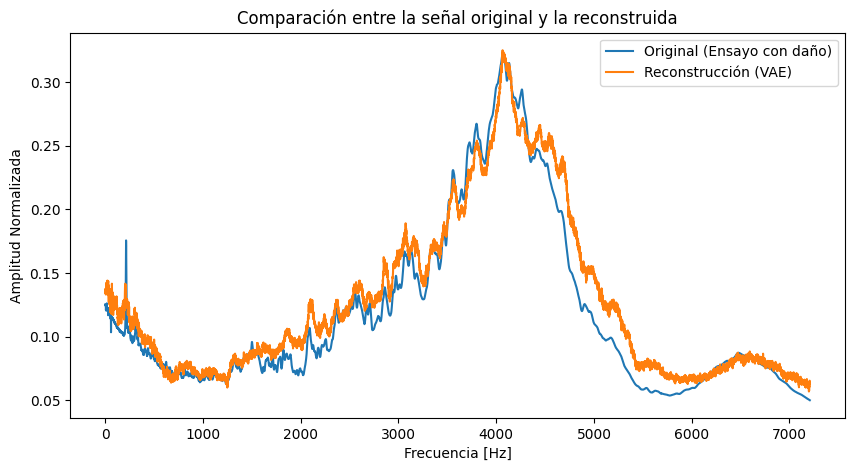

In [91]:
# Evaluación del modelo
def evaluate_model(model, loads_scaled):
    model.eval()
    with torch.no_grad():
        original_signal = loads_scaled[0]
        reconstructed_signal, _, _ = model(original_signal.unsqueeze(0))
        reconstructed_signal = reconstructed_signal.squeeze(0).squeeze(0).detach()
    
    plt.figure(figsize=(10, 5))
    plt.plot(original_signal.squeeze().numpy(), label="Original (Ensayo con daño)")
    plt.plot(reconstructed_signal.numpy(), label="Reconstrucción (VAE)")
    plt.legend()
    plt.title("Comparación entre la señal original y la reconstruida")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Amplitud Normalizada")
    plt.show()

evaluate_model(model, loads_scaled)



In [115]:
# Función de evaluación con señales de ensayo con daño
def evaluate_test_signals(model, loads_scaled):
    model.eval()
    with torch.no_grad():
        for i, test_signal in enumerate(loads_scaled[:30]):
            # Realizar la reconstrucción
            reconstructed_signal = model(test_signal.unsqueeze(0)).squeeze(0).squeeze(0).detach()

            # Gráfico de comparación para cada señal
            plt.figure(figsize=(10, 5))
            plt.plot(data_frecuencias_np_reshaped,test_signal.squeeze().numpy(), label=f"Señal Original (Ensayo con Daño) {i+1}")
            plt.plot(data_frecuencias_np_reshaped,reconstructed_signal.numpy(), label=f"Reconstrucción (Autoencoder) {i+1}", linestyle="dashed")
            plt.legend()
            plt.title(f"Comparación entre señal de ensayo con daño {i+1} y su reconstrucción")
            plt.xlabel("Frecuencia [Hz]")
            plt.ylabel("Amplitud Normalizada")
            plt.show()

evaluate_test_signals(model, loads_scaled)


AttributeError: 'tuple' object has no attribute 'squeeze'